# Introduction

Our objective in this analysis is to review the current user engagement to X.com, find correletation between differnt metics and see if we can create a predictive model using simple linear regression. The business end goal is to answer what needs to be done in order to improve the revenue. 

# Table of Contents

1 - Introduction

2- About the Data Set

3- Data Collection and Understanding

4- Data Wrangling

5- Data Exploration

6- Model Development

7- Model Evaluation

8- Conclusion

# About the Data Set

The data is collected from X.com Google Analytics Web Reporting Platform in a csv format. The collection can be done via Big Query however in this analysis we will use the csv file exported from GA360.

The description of the variables are as follows:

**Client Id: Google Analytics cookie that is unique to each user and lasts approximately 2 years.**

**Sessions: A session is a group of user interactions with the website that take place within a given time frame. Single session can contain multiple page views, events, social interactions, and ecommerce transactions.**

**Avg. Session Duration: Average session duration is: total duration of all sessions (in seconds) / number of sessions.**

**Bounce Rate: Bounce rate is single-page sessions divided by all sessions, or the percentage of all sessions on your site in which users viewed only a single page and triggered only a single request to the Analytics server.**

**Revenue: Revenue in dollars** 

**Transaction: Number of Transactions via the website**

**Goal Converstion Rate: Track of specific user interactions on your site. These user interactions can be anything including form submissions, button clicks, ebook downloads, and more.**

# Data Collection and Understanding 

In [1]:
# import neccessary libraries
import pandas as pd
import numpy as np

In [2]:
# import the data and create the dataframe
df=pd.read_csv('website_data.csv', skiprows=range(6))

In [3]:
# lets look at the overview of our data
df.head(5)

,Client Id,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
0,1.216956e+09,120,00:17:48,1.67%,"$54,632.64",11,65.00%
1,9.071024e+08,4,00:14:40,50.00%,"$18,615.84",4,175.00%
2,8.335800e+08,55,00:07:04,34.55%,"$13,954.70",11,61.82%
3,5.955907e+08,18,00:10:28,11.11%,"$11,391.00",2,144.44%
4,7.223030e+07,32,00:07:35,0.00%,"$7,238.45",5,100.00%


In [4]:
# lets see if there are any missing data
missing_data=df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print('')

Client Id
False    5000
Name: Client Id, dtype: int64

Sessions
False    5000
Name: Sessions, dtype: int64

Avg. Session Duration
False    5000
Name: Avg. Session Duration, dtype: int64

Bounce Rate
False    5000
Name: Bounce Rate, dtype: int64

Revenue
False    5000
Name: Revenue, dtype: int64

Transactions
False    5000
Name: Transactions, dtype: int64

Goal Conversion Rate
False    5000
Name: Goal Conversion Rate, dtype: int64



In [6]:
# lets look at the shape of our data
df.shape

(5000, 7)

In [7]:
# lets look at the data types in our variables
df.dtypes

Client Id                float64
Sessions                   int64
Avg. Session Duration     object
Bounce Rate               object
Revenue                   object
Transactions               int64
Goal Conversion Rate      object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
Client Id                5000 non-null float64
Sessions                 5000 non-null int64
Avg. Session Duration    5000 non-null object
Bounce Rate              5000 non-null object
Revenue                  5000 non-null object
Transactions             5000 non-null int64
Goal Conversion Rate     5000 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 273.5+ KB


When we look at the data set, we see that;

**There are 5000 rows and 7 columns**

**Avg. Session Duration is object**

**Bounce Rate is object and is percentage**

**Revenue is object with $ symbol**

**Goal Conversion Rate is percentage and object**

#### In order to analyze and create the predictive model properly we need to correct some of the data types and values. 

**Update Avg. Session Duration so it shows as total seconds.**
**Convert object data types to numeric type (float and integer) so we can use them in our analysis and model development.**

# Data Wrangling

In [9]:
# create a function to convert percentage to float
def p2f(x):
    return float(x.strip('%'))/100

In [11]:
# update the dataframe
df=pd.read_csv('website_data.csv', skiprows=range(6), converters={'Bounce Rate': p2f, 'Goal Conversion Rate': p2f})

In [12]:
df.head(5)

,Client Id,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
0,1.216956e+09,120,00:17:48,0.0167,"$54,632.64",11,0.6500
1,9.071024e+08,4,00:14:40,0.5000,"$18,615.84",4,1.7500
2,8.335800e+08,55,00:07:04,0.3455,"$13,954.70",11,0.6182
3,5.955907e+08,18,00:10:28,0.1111,"$11,391.00",2,1.4444
4,7.223030e+07,32,00:07:35,0.0000,"$7,238.45",5,1.0000


In [13]:
# update revenue so it is float with no $ sign
df[['Revenue']]=df[['Revenue']].replace('[$,]', '', regex=True).astype('float')

In [14]:
# update Avg. Session Duration to float and total seconds
df['Avg. Session Duration']=pd.to_datetime(df['Avg. Session Duration'], errors='coerce')

In [15]:
df['Avg. Session Duration']=pd.to_timedelta(df['Avg. Session Duration'].dt.strftime('%H:%M:%S'), errors='coerce').dt.total_seconds().astype(int)

In [16]:
df.head(5)

,Client Id,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
0,1.216956e+09,120,1068,0.0167,54632.64,11,0.6500
1,9.071024e+08,4,880,0.5000,18615.84,4,1.7500
2,8.335800e+08,55,424,0.3455,13954.70,11,0.6182
3,5.955907e+08,18,628,0.1111,11391.00,2,1.4444
4,7.223030e+07,32,455,0.0000,7238.45,5,1.0000


# Data Exploration

In [17]:
# lets look at the correlation between the variables
df.corr()

,Client Id,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
Client Id,1.000000,-0.007511,0.000379,-0.006400,0.033550,0.005856,-0.004590
Sessions,-0.007511,1.000000,-0.180569,0.181863,0.318640,0.542989,-0.427249
Avg. Session Duration,0.000379,-0.180569,1.000000,-0.174716,0.033912,-0.020670,0.464290
Bounce Rate,-0.006400,0.181863,-0.174716,1.000000,0.033386,0.026292,-0.323158
Revenue,0.033550,0.318640,0.033912,0.033386,1.000000,0.384126,-0.063508
Transactions,0.005856,0.542989,-0.020670,0.026292,0.384126,1.000000,-0.087564
Goal Conversion Rate,-0.004590,-0.427249,0.464290,-0.323158,-0.063508,-0.087564,1.000000


There is a small negative correlation between Sessions and Avg. Session Duration, this might mean that, even though users visiting the site, they are not consuming the content on the site. 

There is a positive and medium correlation between Sessions and Transaction and Sessions and Revenue. Even though users not engaging with the content, the visits to the site has a positive impact to the transactions and revenue. 

There is a medium negative correlation between goal conversion rate and sessions, alsp positive medium correlation with avg. session duration. Our goal converstion seems to be set up based on avg. session duration of the user.

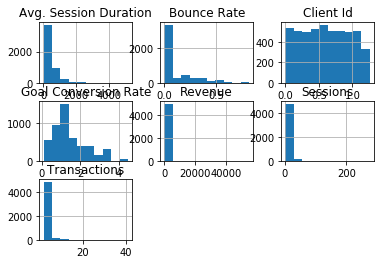

In [20]:
# Lets visualize some of our findings
# import neccessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
df.hist()
plt.show()

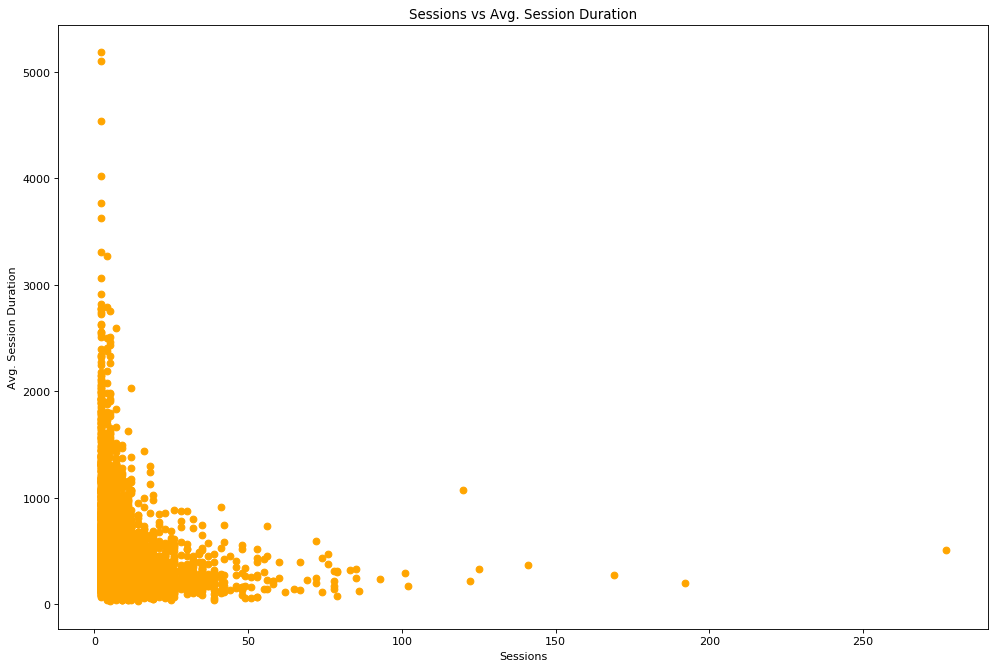

In [28]:
# Lets use scatter plot to visualize the relationship
plt.figure(figsize=(15,10), dpi=80)
plt.scatter(df[['Sessions']], df[['Avg. Session Duration']], color='orange')

plt.title('Sessions vs Avg. Session Duration')
plt.xlabel('Sessions')
plt.ylabel('Avg. Session Duration')

plt.show()

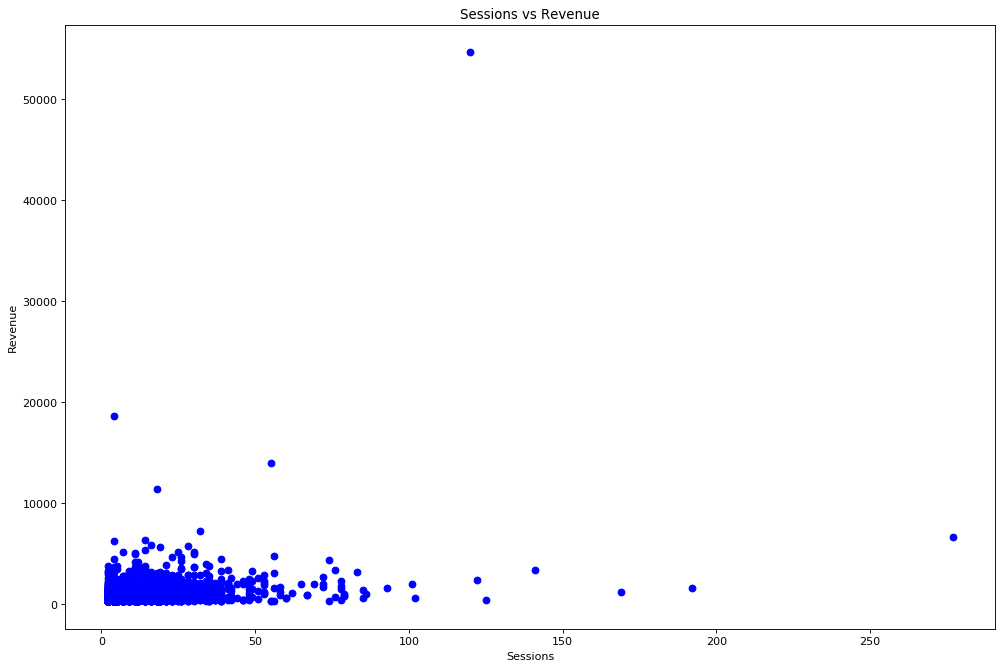

In [29]:
plt.figure(figsize=(15,10), dpi=80)
plt.scatter(df[['Sessions']], df[['Revenue']], color='blue')

plt.title('Sessions vs Revenue')
plt.xlabel('Sessions')
plt.ylabel('Revenue')

plt.show()

We are definately seeing the positive relation betwen Sessions and Revenue. We see Revenue amount being over 50,000 on one particular user engagement with around 140 sessions. However the linear relationship is not very strong. We have Sessions more than 250 however the revenue is around $10,000.

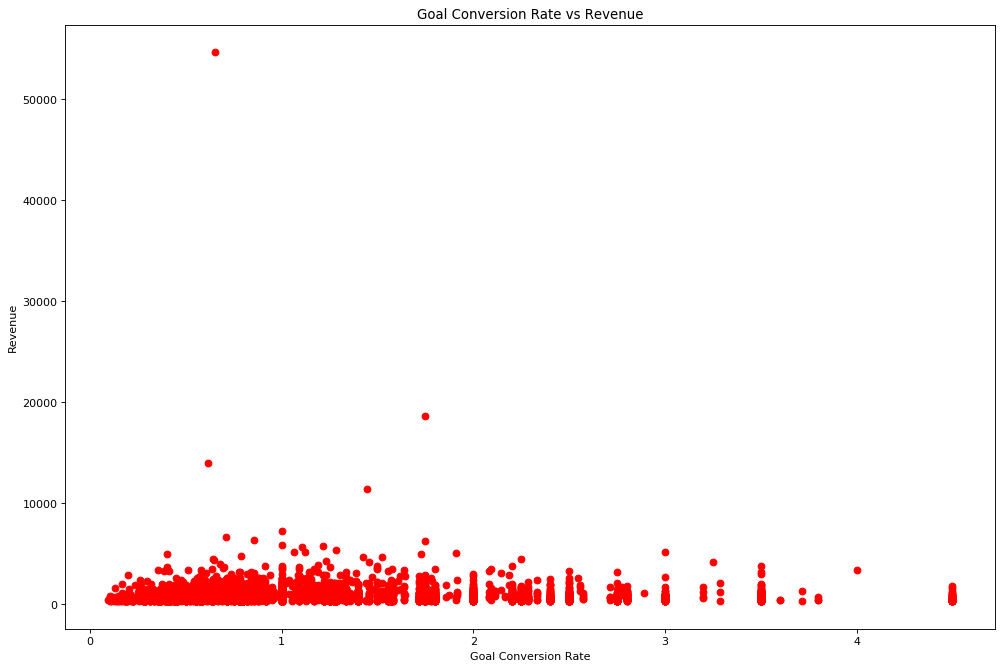

In [30]:
plt.figure(figsize=(15,10), dpi=80)
plt.scatter(df[['Goal Conversion Rate']], df[['Revenue']], color='red')

plt.title('Goal Conversion Rate vs Revenue')
plt.xlabel('Goal Conversion Rate')
plt.ylabel('Revenue')

plt.show()

The Goal Conversion Rate and Revenue has almost no correlation. If there is any it is negative. This might mean that the Revenue metric is not set up as part of the website Goals hence the output does not show any correlation. 

# Model Development

In [32]:
# lets split the data for 80% train and 20% set
msk=np.random.rand(len(df))<0.8
train=df[msk]
test=df[~msk]

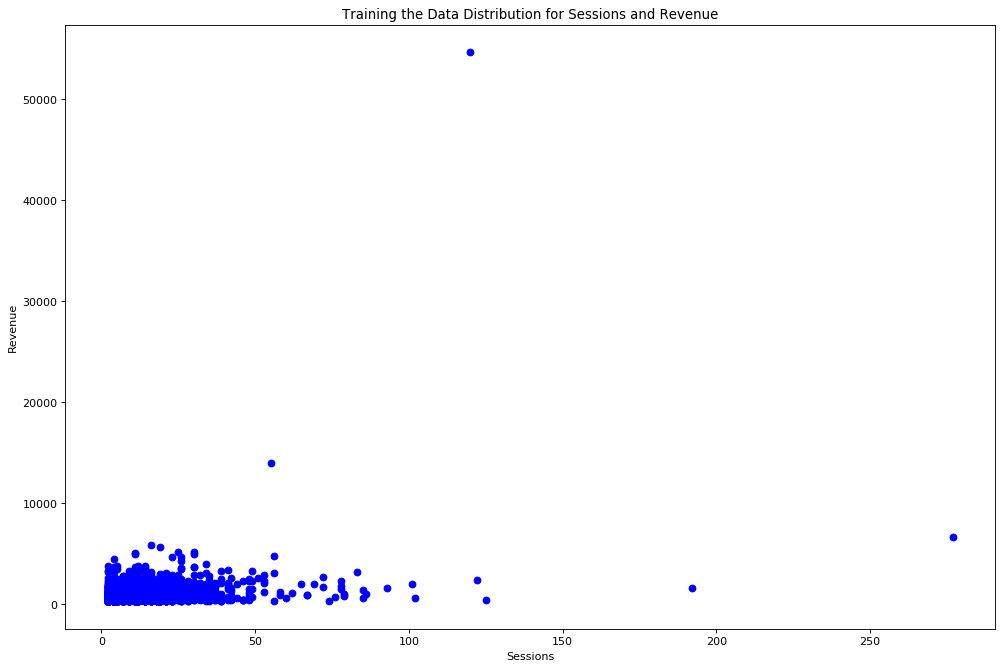

In [35]:
# train the data distribution
plt.figure(figsize=(15,10), dpi=80)
plt.scatter(train['Sessions'], train['Revenue'], color='blue')
plt.title('Training the Data Distribution for Sessions and Revenue')
plt.xlabel('Sessions')
plt.ylabel('Revenue')
plt.show()

In [36]:
# Lets create our model (first import neccessary libraries)
from sklearn import linear_model

In [37]:
regr=linear_model.LinearRegression()

In [38]:
train_x=np.asanyarray(train[['Sessions']])
train_y=np.asanyarray(train[['Revenue']])

In [39]:
regr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
# lets see the coefficient and the intercept values
print(regr.coef_)
print(regr.intercept_)

[[32.25248928]]
[431.8813446]


Text(0, 0.5, 'Revenue')

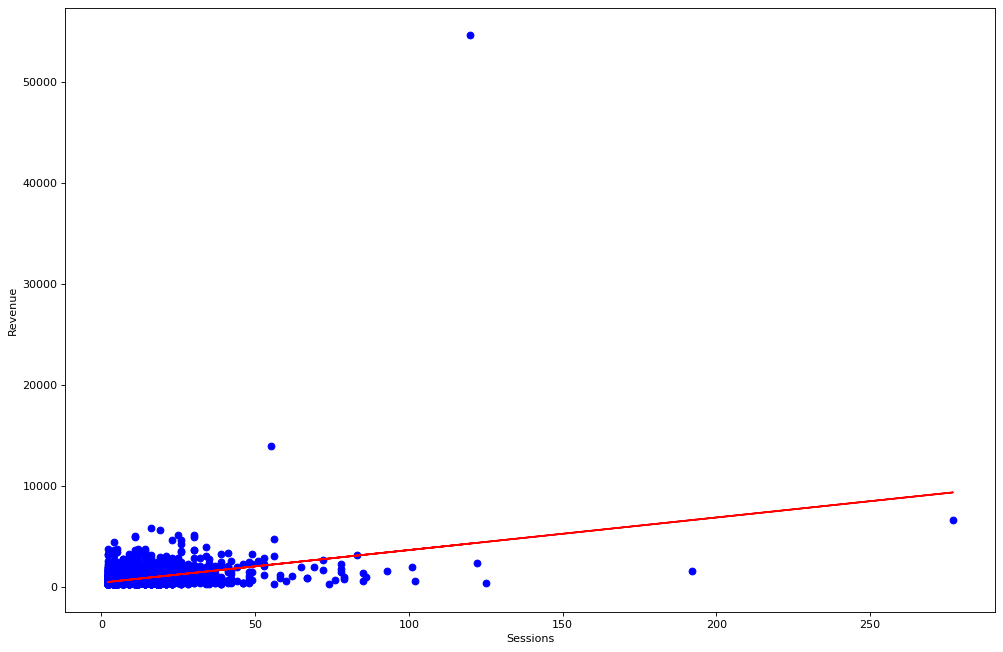

In [44]:
#Lets look at the outputs based on our model
plt.figure(figsize=(15,10), dpi=80)
plt.scatter(train['Sessions'], train['Revenue'], color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x +regr.intercept_[0], '-r')
plt.xlabel('Sessions')
plt.ylabel('Revenue')

# Model Evaluation

To evaluate the simple linear regression model we created we can look at the mean absoulute error (MAE), mean squared error(MSE), Root Mean Squared Error(RMSE).

In [45]:
# import neccessary libraries
from sklearn.metrics import r2_score

In [46]:
test_x = np.asanyarray(test[['Sessions']])
test_y = np.asanyarray(test[['Revenue']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

Mean absolute error: 423.49
Residual sum of squares (MSE): 888085.32
R2-score: -5.30


# Conclusion
After analyzing the site metrics and user engagement, we see that there are correlations between Sessions / Revenue and Sessions / Avg. Session Durations, however the correlation is weak. Avg. Session Durations shows us that, the users are visiting the website, however not engaging with the content. This might be due to content not being updated often. New content with updated release calender can increase the Avg.Session Durations. 

Another insight we see is that, Avg. Session Durations does not have any impact to the revenue and the transaction. This means the transactions are due to direct page visit for conversion. This might be because of Paid or other Campaigns directing users to the site just to make a purchase rather than engaging with the website content. 

Based on our analysis, we recommend to create new content for further engagement, possibly exploring replacement of Paid Campaigns with imprvement of organic search for acqusition. Goal Conversion Rate has almost no correlation with the Revenue metric. If the business goal is to increase revenue through the website, the goals set up in GA360 should be updated to reflect the actual business objective.

Creating a predictive model using simple linear regression is possible and easy to execute using Sessions and Revenue however, the correlation between these two variables are not strong enough to create an accurate model. The negative R2 score indicates that the predictive model we created by training 80% of the data set and using 20% as test data is not a good and needs further improvement.